# This demo run AnyV2V(i2vgen-xl) pipeline on a single video

# Step 0. Black-box image editing

In [1]:
from moviepy.editor import VideoFileClip
import numpy as np
import os

In [2]:
from PIL import Image
def infer_video(model, video_path, output_dir, prompt, force_512=False, seed=42, negative_prompt=""):
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_clip = VideoFileClip(video_path)
    video_filename = os.path.basename(video_path)
    # filename_noext = os.path.splitext(video_filename)[0]
    
    # Create the output directory if it does not exist
    # final_output_dir = os.path.join(output_dir, filename_noext)
    final_output_dir = output_dir
    if not os.path.exists(final_output_dir):
        os.makedirs(final_output_dir)

    result_path = os.path.join(final_output_dir, prompt + ".png")
    
    # Check if result already exists
    # if os.path.exists(result_path):
    #     print(f"Result already exists: {result_path}")
    #     return

    def process_frame(image):
        pil_image = Image.fromarray(image)
        if force_512:
            pil_image = pil_image.resize((512, 512), Image.LANCZOS)
        result = model.infer_one_image(pil_image, instruct_prompt=prompt, seed=seed, negative_prompt=negative_prompt)
        if force_512:
            result = result.resize(video_clip.size, Image.LANCZOS)
        return np.array(result)
    
    # Process only the first frame
    first_frame = video_clip.get_frame(0)  # Get the first frame
    processed_frame = process_frame(first_frame)  # Process the first frame

    Image.fromarray(processed_frame).save(result_path)
    print(f"Processed and saved the first frame: {result_path}")

In [3]:
import sys
sys.path.append('..')
from black_box_image_edit import InstructPix2Pix
black_box_image_model = InstructPix2Pix()
video_path = "../demo/An Old Man Doing Exercises For The Body And Mind.mp4"
output_dir = "../demo/An Old Man Doing Exercises For The Body And Mind/edited_first_frame"
prompt = "turn man into robot"
infer_video(black_box_image_model, video_path, output_dir, prompt, seed=55)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processed and saved the first frame: ../demo/An Old Man Doing Exercises For The Body And Mind/edited_first_frame/turn man into robot.png


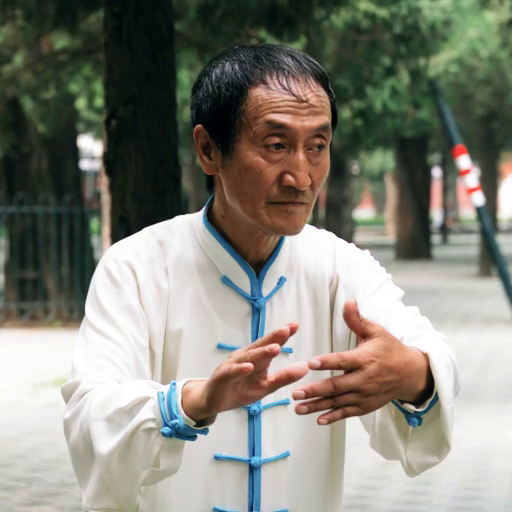

In [4]:
from IPython.display import Image
import os

# Display an image file
Image(filename=os.path.join("../demo/An Old Man Doing Exercises For The Body And Mind"  , "00000.png"))

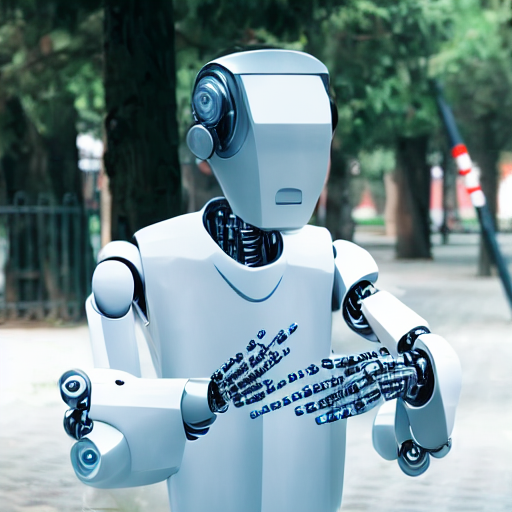

In [5]:
Image(filename=os.path.join("../demo/An Old Man Doing Exercises For The Body And Mind/edited_first_frame","turn man into robot.png"))

# Step 1. DDIM Inversion

In [6]:
import os
import sys
from pathlib import Path
import torch
import argparse
import logging
from omegaconf import OmegaConf
from PIL import Image
import json

# HF imports
from diffusers import (
    DDIMInverseScheduler,
    DDIMScheduler,
)
from diffusers.utils import load_image, export_to_video, export_to_gif

# Project imports
from utils import (
    seed_everything,
    load_video_frames,
    convert_video_to_frames,
    load_ddim_latents_at_T,
    load_ddim_latents_at_t,
)
from pipelines.pipeline_i2vgen_xl import I2VGenXLPipeline
from run_group_ddim_inversion import ddim_inversion, ddim_sampling

In [7]:
# Set up an example inversion config file
config = {
    # General
    "seed": 8888,
    "device": "cuda:7",  # <-- change this to the GPU you want to use
    "debug": False,  # For logging DEBUG level messages otherwise INFO

    # Dir
    "data_dir": "..",  # <-- change this to the path of the data directory, if you cloned the repo, leave it as "..", the inversion latents will be saved in AnyV2V/inversions/
    "model_name": "i2vgen-xl",
    "exp_name": "${video_name}",
    "output_dir": "${data_dir}/inversions/${model_name}/${exp_name}",

    # Data
    "image_size": [512, 512],
    "video_dir": "${data_dir}/demo",
    "video_name": "An Old Man Doing Exercises For The Body And Mind",
    "video_frames_path": "${video_dir}/${video_name}",

    # DDIM settings
    "n_frames": 16,

    # DDIM inversion
    "inverse_config": {
        "image_size": "${image_size}",
        "n_frames": "${n_frames}",
        "cfg": 1.0,
        "target_fps": 8,
        "prompt": "",
        "negative_prompt": "",
        "n_steps": 500,
        "output_dir": "${output_dir}/ddim_latents",
    },

    # DDIM reconstruction
    "recon_config": {
        "enable_recon": False,
        "image_size": "${image_size}",
        "n_frames": "${n_frames}",
        "cfg": 9.0,
        "target_fps": 8,
        "prompt": "",
        "negative_prompt": "Distorted, discontinuous, Ugly, blurry, low resolution, motionless, static, disfigured, disconnected limbs, Ugly faces, incomplete arms",
        "n_steps": 50,
        "ddim_init_latents_t_idx": 3,  # 0 for 981, 3 for 921, 9 for 801, 20 for 581 if n_steps=50
        "ddim_latents_path": "${inverse_config.output_dir}"
    }
}

# Convert the dictionary to an OmegaConf object
config = OmegaConf.create(config)

In [8]:
# Set up logging
logging_level = logging.DEBUG if config.debug else logging.INFO
logging.basicConfig(level=logging_level, format="%(asctime)s - %(levelname)s - [%(funcName)s] - %(message)s")
logger = logging.getLogger(__name__)
logger.info(f"config: {OmegaConf.to_yaml(config)}")

# Set up device and seed
device = torch.device(config.device)
torch.set_grad_enabled(False)
seed_everything(config.seed)

2024-03-23 09:10:19,935 - INFO - [<module>] - config: seed: 8888
device: cuda:7
debug: false
data_dir: ..
model_name: i2vgen-xl
exp_name: ${video_name}
output_dir: ${data_dir}/inversions/${model_name}/${exp_name}
image_size:
- 512
- 512
video_dir: ${data_dir}/demo
video_name: An Old Man Doing Exercises For The Body And Mind
video_frames_path: ${video_dir}/${video_name}
n_frames: 16
inverse_config:
  image_size: ${image_size}
  n_frames: ${n_frames}
  cfg: 1.0
  target_fps: 8
  prompt: ''
  negative_prompt: ''
  n_steps: 500
  output_dir: ${output_dir}/ddim_latents
recon_config:
  enable_recon: false
  image_size: ${image_size}
  n_frames: ${n_frames}
  cfg: 9.0
  target_fps: 8
  prompt: ''
  negative_prompt: Distorted, discontinuous, Ugly, blurry, low resolution, motionless,
    static, disfigured, disconnected limbs, Ugly faces, incomplete arms
  n_steps: 50
  ddim_init_latents_t_idx: 3
  ddim_latents_path: ${inverse_config.output_dir}



In [9]:
logger.info(f"Loading frames from: {config.video_frames_path}")
_, frame_list = load_video_frames(config.video_frames_path, config.n_frames, config.image_size)

2024-03-23 09:10:19,977 - INFO - [<module>] - Loading frames from: ../demo/An Old Man Doing Exercises For The Body And Mind


In [10]:
# Initialize the pipeline
pipe = I2VGenXLPipeline.from_pretrained(
        "ali-vilab/i2vgen-xl",
        torch_dtype=torch.float16,
        variant="fp16",
)
pipe.to(device)
g = torch.Generator(device=device)
g = g.manual_seed(config.seed)

# Initialize the DDIM inverse scheduler
inverse_scheduler = DDIMInverseScheduler.from_pretrained(
        "ali-vilab/i2vgen-xl",
        subfolder="scheduler",
)
# Initialize the DDIM scheduler
ddim_scheduler = DDIMScheduler.from_pretrained(
        "ali-vilab/i2vgen-xl",
        subfolder="scheduler",
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'attention_head_dim': 64} were passed to I2VGenXLUNet, but are not expected and will be ignored. Please verify your config.json configuration file.


In [11]:
first_frame = frame_list[0]  # Is a PIL image
_ddim_latents = ddim_inversion(config.inverse_config, first_frame, frame_list, pipe, inverse_scheduler, g)
# Reconstruction
recon_config = config.recon_config
if recon_config.enable_recon:
            ddim_init_latents_t_idx = recon_config.ddim_init_latents_t_idx
            ddim_scheduler.set_timesteps(recon_config.n_steps)
            logger.info(f"ddim_scheduler.timesteps: {ddim_scheduler.timesteps}")
            ddim_latents_path = recon_config.ddim_latents_path
            ddim_latents_at_t = load_ddim_latents_at_t(
                ddim_scheduler.timesteps[ddim_init_latents_t_idx],
                ddim_latents_path=ddim_latents_path,
            )
            logger.debug(f"ddim_scheduler.timesteps[t_idx]: {ddim_scheduler.timesteps[ddim_init_latents_t_idx]}")
            reconstructed_video = ddim_sampling(
                recon_config,
                first_frame,
                ddim_latents_at_t,
                pipe,
                ddim_scheduler,
                ddim_init_latents_t_idx,
                g,
            )

            # Save the reconstructed video
            os.makedirs(config.output_dir, exist_ok=True)
            # Downsampling the video for space saving
            reconstructed_video = [frame.resize((512, 512), resample=Image.LANCZOS) for frame in reconstructed_video]
            export_to_video(
                reconstructed_video,
                os.path.join(config.output_dir, "ddim_reconstruction.mp4"),
                fps=10,
            )
            export_to_gif(
                reconstructed_video,
                os.path.join(config.output_dir, "ddim_reconstruction.gif"),
            )
            logger.info(f"Saved reconstructed video to {config.output_dir}")

2024-03-23 09:10:24,594 - INFO - [invert] - height: 512, width: 512
2024-03-23 09:10:24,602 - INFO - [invert] - prompt: 


  0%|          | 0/500 [00:00<?, ?it/s]

2024-03-23 09:10:25,663 - INFO - [invert] - saved noisy latents at t=1 to ../inversions/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/ddim_latents
2024-03-23 09:10:26,067 - INFO - [invert] - saved noisy latents at t=3 to ../inversions/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/ddim_latents
2024-03-23 09:10:26,470 - INFO - [invert] - saved noisy latents at t=5 to ../inversions/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/ddim_latents
2024-03-23 09:10:26,874 - INFO - [invert] - saved noisy latents at t=7 to ../inversions/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/ddim_latents
2024-03-23 09:10:27,276 - INFO - [invert] - saved noisy latents at t=9 to ../inversions/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/ddim_latents
2024-03-23 09:10:27,679 - INFO - [invert] - saved noisy latents at t=11 to ../inversions/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/ddim_latents
2024-03-23 09:10:28,084 - INFO - [inver

# Step 2. DDIM Sampling + PnP feature and attention injection

In [12]:
import torch
import argparse
import logging
from omegaconf import OmegaConf
from PIL import Image
import json

# HF imports
from diffusers import (
    DDIMInverseScheduler,
    DDIMScheduler,
)
from diffusers.utils import load_image, export_to_video, export_to_gif

# Project imports
from utils import (
    seed_everything,
    load_video_frames,
    convert_video_to_frames,
    load_ddim_latents_at_T,
    load_ddim_latents_at_t,
)
from pipelines.pipeline_i2vgen_xl import I2VGenXLPipeline
from pnp_utils import (
    register_time,
    register_conv_injection,
    register_spatial_attention_pnp,
    register_temp_attention_pnp,
)

from run_group_pnp_edit import init_pnp

In [13]:
# Set up an example sampling config file
config = {
    # General
    "seed": 8888,
    "device": "cuda:4",  # <-- change this to the GPU you want to use
    "debug": False,  # For logging DEBUG level messages otherwise INFO

    # Dir
    "data_dir": "..",  # <-- change this to the path of the data directory, if you cloned the repo, leave it as "..", the inversion latents will be saved in AnyV2V/
    "model_name": "i2vgen-xl",
    "task_name": "Prompt-Based-Editing",
    "edited_video_name": "a robot doing exercises for the body and mind",
    "output_dir": "${data_dir}/Results/${task_name}/${model_name}/${video_name}/${edited_video_name}/",

    # Data
    "image_size": [512, 512],
    "video_dir": "${data_dir}/demo",
    "video_name":"An Old Man Doing Exercises For The Body And Mind",
    "video_frames_path": "${video_dir}/${video_name}",
    "edited_first_frame_path":"${data_dir}/demo/An Old Man Doing Exercises For The Body And Mind/edited_first_frame/turn man into robot.png",
    "ddim_latents_path": "${data_dir}/inversions/${model_name}/${video_name}/ddim_latents",  # Same as inverse_config.output_dir

    # Pnp Editing
    "n_frames": 16,
    "cfg": 9.0,
    "target_fps": 8,
    "editing_prompt":"a man doing exercises for the body and mind",
    "editing_negative_prompt": "Distorted, discontinuous, Ugly, blurry, low resolution, motionless, static, disfigured, disconnected limbs, Ugly faces, incomplete arms",
    "n_steps": 50,
    "ddim_init_latents_t_idx": 0,  # 0 for 981, 3 for 921, 9 for 801, 20 for 581 if n_steps=50
    "ddim_inv_prompt": "",
    "random_ratio": 0.0,

    # Pnp config
    "pnp_f_t": 1.0,
    "pnp_spatial_attn_t": 1.0,
    "pnp_temp_attn_t":1.0
}

# Convert the dictionary to an OmegaConf object
config = OmegaConf.create(config)

In [14]:
# Set up logging
logging_level = logging.DEBUG if config.debug else logging.INFO
logging.basicConfig(level=logging_level, format="%(asctime)s - %(levelname)s - [%(funcName)s] - %(message)s")
logger = logging.getLogger(__name__)
logger.info(f"config: {OmegaConf.to_yaml(config)}")

# Set up device and seed
device = torch.device(config.device)
torch.set_grad_enabled(False)
seed_everything(config.seed)


src_frame_list = frame_list # Loaded from step 1
src_1st_frame = src_frame_list[0]  # Is a PIL image

# Load the edited first frame
edited_1st_frame = load_image(config.edited_first_frame_path)
edited_1st_frame = edited_1st_frame.resize(config.image_size, resample=Image.Resampling.LANCZOS)

# Load the initial latents at t
ddim_init_latents_t_idx = config.ddim_init_latents_t_idx
ddim_scheduler.set_timesteps(config.n_steps)
logger.info(f"ddim_scheduler.timesteps: {ddim_scheduler.timesteps}")
ddim_latents_at_t = load_ddim_latents_at_t(
            ddim_scheduler.timesteps[ddim_init_latents_t_idx], ddim_latents_path=config.ddim_latents_path
        )
logger.debug(f"ddim_scheduler.timesteps[t_idx]: {ddim_scheduler.timesteps[ddim_init_latents_t_idx]}")
logger.debug(f"ddim_latents_at_t.shape: {ddim_latents_at_t.shape}")

# Blend the latents
random_latents = torch.randn_like(ddim_latents_at_t)
logger.info(f"Blending random_ratio (1 means random latent): {config.random_ratio}")
mixed_latents = random_latents * config.random_ratio + ddim_latents_at_t * (1 - config.random_ratio)

# Init Pnp
init_pnp(pipe, ddim_scheduler, config)

# Edit video
pipe.register_modules(scheduler=ddim_scheduler)
edited_video = pipe.sample_with_pnp(
            prompt=config.editing_prompt,
            image=edited_1st_frame,
            height=config.image_size[1],
            width=config.image_size[0],
            num_frames=config.n_frames,
            num_inference_steps=config.n_steps,
            guidance_scale=config.cfg,
            negative_prompt=config.editing_negative_prompt,
            target_fps=config.target_fps,
            latents=mixed_latents,
            generator=torch.manual_seed(config.seed),
            return_dict=True,
            ddim_init_latents_t_idx=ddim_init_latents_t_idx,
            ddim_inv_latents_path=config.ddim_latents_path,
            ddim_inv_prompt=config.ddim_inv_prompt,
            ddim_inv_1st_frame=src_1st_frame,
).frames[0]

# Save video
# Add the config to the output_dir,
config_suffix = (
            "ddim_init_latents_t_idx_"
            + str(ddim_init_latents_t_idx)
            + "_nsteps_"
            + str(config.n_steps)
            + "_cfg_"
            + str(config.cfg)
            + "_pnpf"
            + str(config.pnp_f_t)
            + "_pnps"
            + str(config.pnp_spatial_attn_t)
            + "_pnpt"
            + str(config.pnp_temp_attn_t)
)
output_dir = os.path.join(config.output_dir, config_suffix)
os.makedirs(output_dir, exist_ok=True)
edited_video = [frame.resize(config.image_size, resample=Image.LANCZOS) for frame in edited_video]
edited_video_file_name = "video"
export_to_video(edited_video, os.path.join(output_dir, f"{edited_video_file_name}.mp4"), fps=config.target_fps)
export_to_gif(edited_video, os.path.join(output_dir, f"{edited_video_file_name}.gif"))
logger.info(f"Saved video to: {os.path.join(output_dir, f'{edited_video_file_name}.mp4')}")
logger.info(f"Saved gif to: {os.path.join(output_dir, f'{edited_video_file_name}.gif')}")
for i, frame in enumerate(edited_video):
      frame.save(os.path.join(output_dir, f"{edited_video_file_name}_{i:05d}.png"))
      logger.info(f"Saved frames to: {os.path.join(output_dir, f'{edited_video_file_name}_{i:05d}.png')}")

2024-03-23 09:13:51,413 - INFO - [<module>] - config: seed: 8888
device: cuda:4
debug: false
data_dir: ..
model_name: i2vgen-xl
task_name: Prompt-Based-Editing
edited_video_name: a robot doing exercises for the body and mind
output_dir: ${data_dir}/Results/${task_name}/${model_name}/${video_name}/${edited_video_name}/
image_size:
- 512
- 512
video_dir: ${data_dir}/demo
video_name: An Old Man Doing Exercises For The Body And Mind
video_frames_path: ${video_dir}/${video_name}
edited_first_frame_path: ${data_dir}/demo/An Old Man Doing Exercises For The Body
  And Mind/edited_first_frame/turn man into robot.png
ddim_latents_path: ${data_dir}/inversions/${model_name}/${video_name}/ddim_latents
n_frames: 16
cfg: 9.0
target_fps: 8
editing_prompt: a man doing exercises for the body and mind
editing_negative_prompt: Distorted, discontinuous, Ugly, blurry, low resolution, motionless,
  static, disfigured, disconnected limbs, Ugly faces, incomplete arms
n_steps: 50
ddim_init_latents_t_idx: 0
ddim

  0%|          | 0/50 [00:00<?, ?it/s]

2024-03-23 09:14:53,312 - INFO - [<module>] - Saved video to: ../Results/Prompt-Based-Editing/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/a robot doing exercises for the body and mind/ddim_init_latents_t_idx_0_nsteps_50_cfg_9.0_pnpf1.0_pnps1.0_pnpt1.0/video.mp4
2024-03-23 09:14:53,313 - INFO - [<module>] - Saved gif to: ../Results/Prompt-Based-Editing/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/a robot doing exercises for the body and mind/ddim_init_latents_t_idx_0_nsteps_50_cfg_9.0_pnpf1.0_pnps1.0_pnpt1.0/video.gif
2024-03-23 09:14:53,410 - INFO - [<module>] - Saved frames to: ../Results/Prompt-Based-Editing/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/a robot doing exercises for the body and mind/ddim_init_latents_t_idx_0_nsteps_50_cfg_9.0_pnpf1.0_pnps1.0_pnpt1.0/video_00000.png
2024-03-23 09:14:53,507 - INFO - [<module>] - Saved frames to: ../Results/Prompt-Based-Editing/i2vgen-xl/An Old Man Doing Exercises For The Body And Mind/a robot do

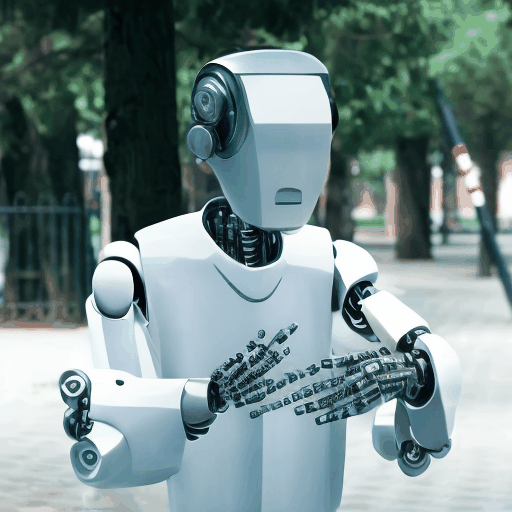

In [15]:
from IPython.display import Image, display

output_video_path = os.path.join(output_dir, "video.gif")
display(Image(filename=output_video_path))